## Plot

In [1]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from getdist import plots
from cosmoprimo.fiducial import DESI
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.samples import Profiles, plotting, Chain
from desilike import setup_logging
setup_logging()  # for logging messages

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

2024-11-08 01:42:00.664436: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# the tracers for DESI mocks
tracers = {
    'ELG_lowz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 0.8,
        'zmax': 1.1,
        'zeff': 0.98,
        'ran_mock_num': '10'
    },
    'ELG_highz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 1.1,
        'zmax': 1.6,
        'zeff': 1.325,
        'ran_mock_num': '10'
    },
}

def set_true_values(params, catalogue='LCDM'):
    # true values for the AbacusSummit simulation
    update_values = {
        'LCDM': {'h':0.6736, 'omega_cdm': 0.1200, 'Omega_cdm': 0.2685, 'omega_b':0.02207,'logA': 3.0364, 'm_ncdm': 0.0, 'n_s':0.9624, 'w0_fld':-1.0, 'fc':0.01},
    }
    if catalogue in update_values:
        truth_values = update_values[catalogue]
    return [truth_values[param] for param in params if param in truth_values]

In [3]:
MOCKNUM = 0
survey  ='Y1'
specver ='iron'
mockver ='v4_2'
tracer_type = 'ELG_lowz' # 'ELG_lowz', 'ELG_highz', 
region = "GCcomb"  # NGC, SGC or GCcomb

if tracer_type in tracers:
    settings = tracers[tracer_type]
    tracer = settings['tracer']
    zmin = settings['zmin']
    zmax = settings['zmax']
    zeff = settings['zeff']
    ran_mock_num = settings['ran_mock_num']
else:
    raise ValueError(f"Unknown ztype: {tracer_type}")

pk_dir = f'/pscratch/sd/s/shengyu/statistics/{tracer}/pk/'
cov_dir = f'/global/cfs/cdirs/desi/survey/catalogs/{survey}/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'
mock_dir = f'/pscratch/sd/s/shengyu/mocks/{survey}/Abacus_{mockver}/altmtl{MOCKNUM}/{specver}/mock{MOCKNUM}/LSScats/'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z{zmin}-{zmax}_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(0, 1000):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [26]:
cosmology = 'LCDM'
theory = 'FOLPS'

burnin      = 0.80
slice_step  = 1000

colors      =  ['C0','C3','C4']
lss         = ['--', '--', '--']
filleds     = [True, False, False]
lws         = [2.0, 2.0, 2.0]

samples = []
r_pks = ['','_realistic','_failures']
for r_pk in r_pks:
    chain_fn    = f'./results/samples/{cosmology}/chain_{tracer}_{region}_z{zeff}{r_pk}.npy'
    chain       = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]
    # print(chain.to_stats(tablefmt='pretty'))
    samples.append(chain)


[000755.67] [0/1] 11-08 01:54  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_GCcomb_z0.98.npy.
[000755.69] [0/1] 11-08 01:54  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_GCcomb_z0.98_realistic.npy.
[000755.72] [0/1] 11-08 01:54  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_GCcomb_z0.98_failures.npy.


Removed no burn in
Removed no burn in
Removed no burn in


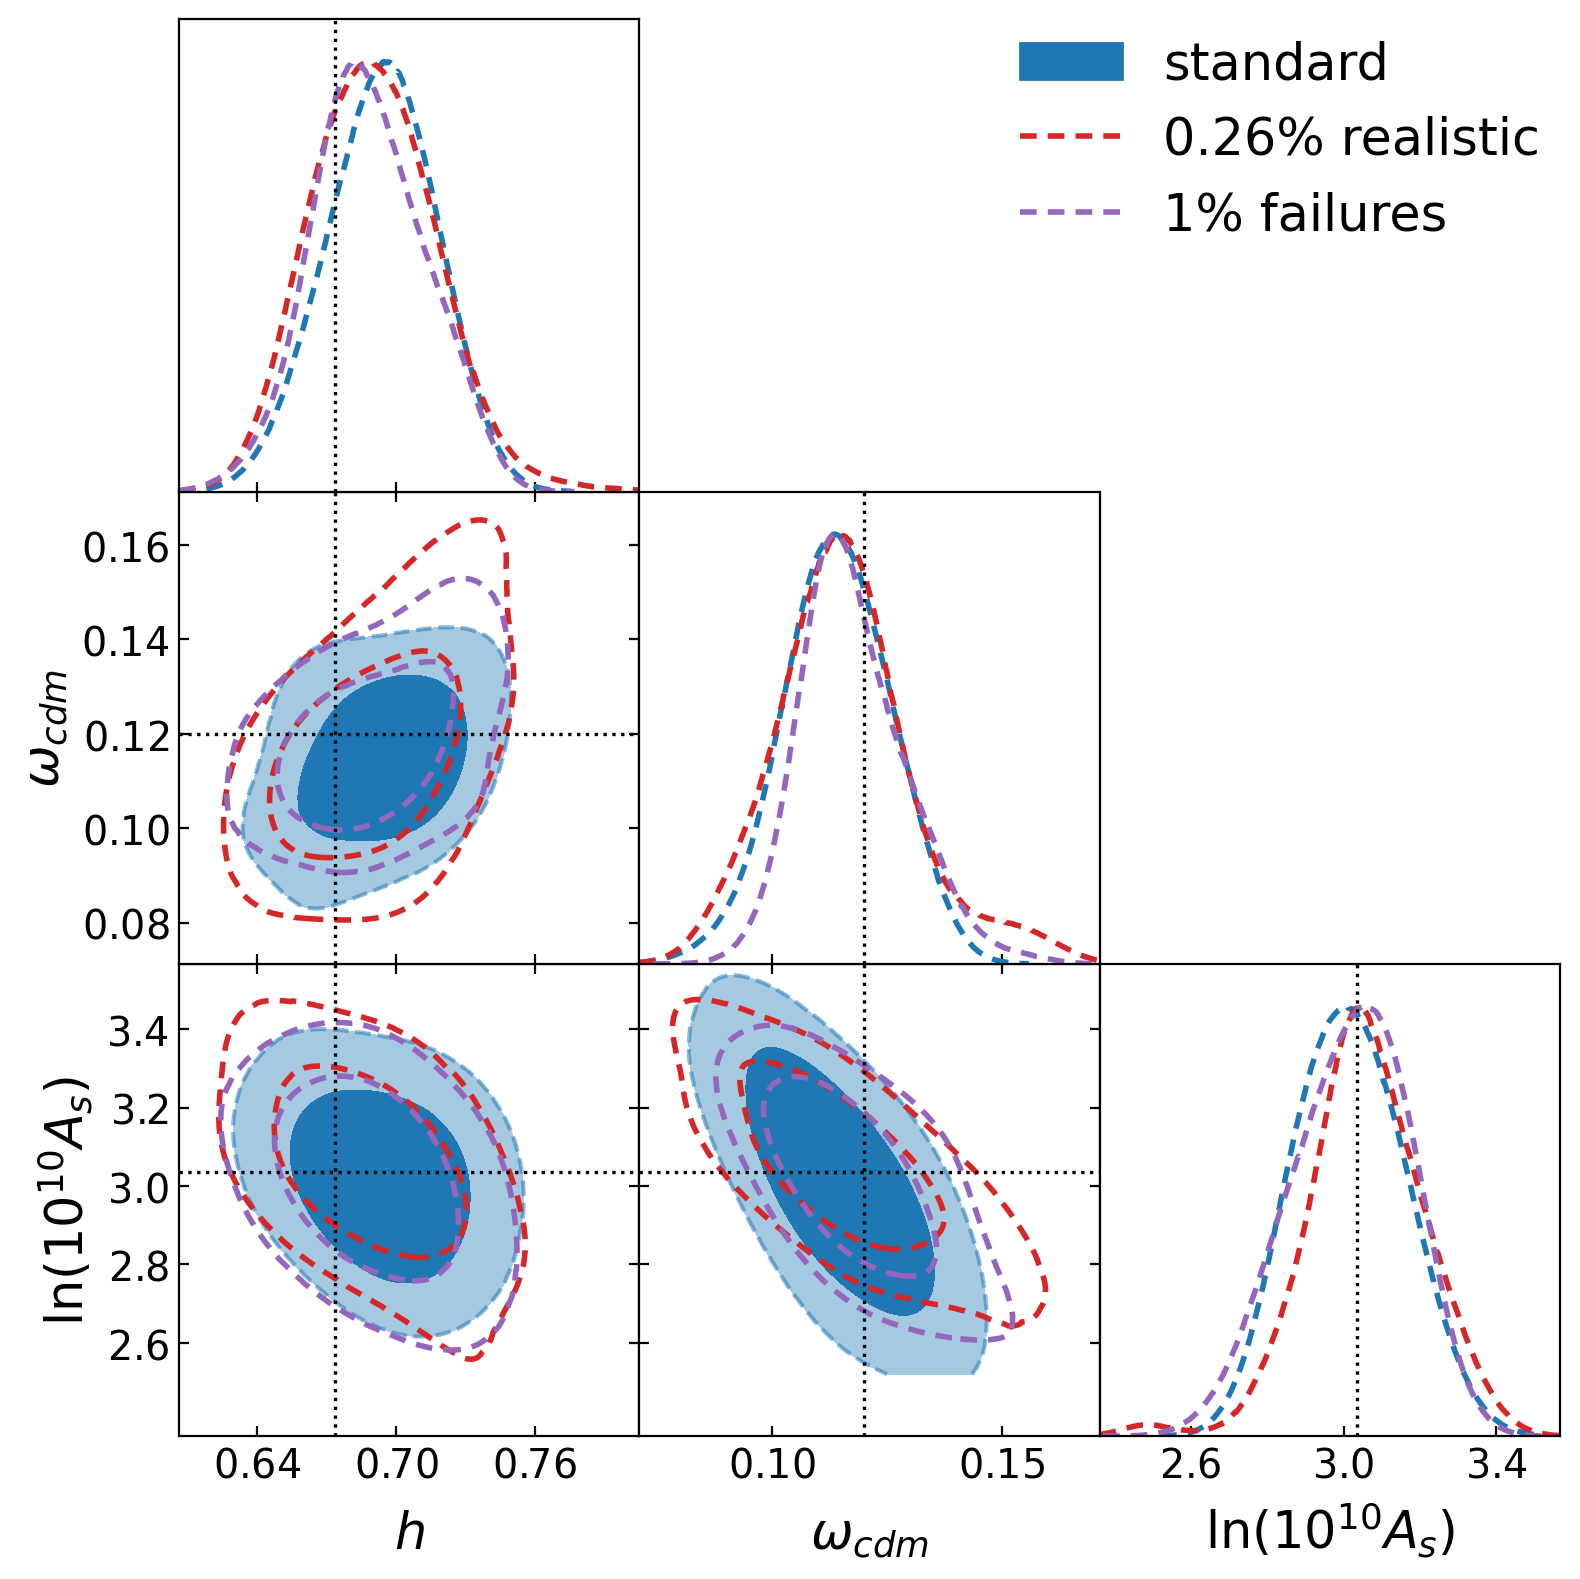

In [27]:
params= ['h','omega_cdm','logA']

# plot the corner posterior
g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.axes_fontsize = 16
g.settings.figure_legend_frame = False
    
def plot_cosparams():
    plotting.plot_triangle(samples, params = params, title_limit=0, filled = filleds,
                               legend_labels = ['standard', '0.26% realistic', '1% failures'], legend_loc= 'upper right',
                            #    legend_labels = [r'clean', r'1% catas', r'5% catas'], legend_loc= 'upper right',
                                # legend_labels=[],
                                contour_ls = lss, contour_lws = lws, contour_colors = colors, 
                                # param_limits=param_limits, 
                                smoothed=True, g=g)
    true_values = set_true_values(params)
    for i in range(len(true_values)):
        for j in range(i+1):
            g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
            if i != j:
                g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)
plot_cosparams()

# plt.figtext(0.63, 0.82, r'$f_c = 1\%$', fontsize=20)
# plt.figtext(0.63, 0.75, r'$V_{100} = 100 \, h^{-3} \rm{Gpc}^3$', fontsize=20)
# plt.figtext(0.62, 0.7, r'$k \in [0.02,0.2] \, h/\rm{Gpc}$', fontsize=20)
# axs[0].set_ylim([10**(-5),10**4])
# patch2 = mpatches.Patch(color='C3', label=r'{}% catas & FOLPS'.format(int(fc*100)))
# patch1 = mpatches.Patch(color='C0', label=r'{}% catas & FOLPS+$f_c$'.format(int(fc*100)))
# leg1 = plt.legend(handles=[patch2, patch1], fontsize = 20)
# leg1.get_frame().set_linewidth(0.0)
g.export(dpi=400)